# Step 4: Preprocessing & Feature Engineering

Load the final data from steps 2 & 3, create our target variable (and any other relevant features), then scale and prepare data for modelling.

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# Load final data
data = pd.read_csv('data/processed/data.csv')
data.head()

Unnamed: 0 customer invoice_date  qty_shipped             item  \
0           0   1HOLPS   2015-05-08          1.0            T3000   
1           3   1VANAI   2015-04-17          2.0     AAM27QNH9LA1   
2           4   1VANAI   2015-04-17          2.0  SEC1223MOTOTRBO   
3           5   1VANAI   2015-04-17          2.0       0180355A80   
4           6   1VANAI   2015-04-17          2.0       0180352A11   

                      description  item_price customer.1       industry  \
0         MOTO MTR3000 BASE RADIO      6020.8     1HOLPS  K12 Education   
1   XPR 4550 403-470 1-25W 160 CH       681.0     1VANAI     Healthcare   
2  SAMLEX BASE STATION PWR SUPPLY       156.0     1VANAI     Healthcare   
3  SPECTRUM MAGNETIC MNT  MINIUHF        28.5     1VANAI     Healthcare   
4    ANTENNA 1/4 WAVE 450-470 MHZ        12.0     1VANAI     Healthcare   

    contact_owner  lifetime_sales  first_sale  county  market_opportunity  \
0   Keith Johnson        39760.49  11/01/1999  Ottawa            825673.0   
1  Skip Petrovich        25907.89  10/25/2004    Kent           1601574.0   
2  Skip Petrovich        25907.89  10/25/2004    Kent           1601574.0   
3  Skip Petrovich        25907.89  10/25/2004    Kent           1601574.0   
4  Skip Petrovich        25907.89  10/25/2004    Kent           1601574.0   

   %_market_opp  
0         0.309  
1         0.421  
2         0.421  
3         0.421  
4         0.421

In [3]:
data.columns

Index(['Unnamed: 0', 'customer', 'invoice_date', 'qty_shipped', 'item',
       'description', 'item_price', 'customer.1', 'industry', 'contact_owner',
       'lifetime_sales', 'first_sale', 'county', 'market_opportunity',
       '%_market_opp'],
      dtype='object')

In [4]:
data.drop(['Unnamed: 0','customer.1'], inplace=True, axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7890 entries, 0 to 7889
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer            7890 non-null   object 
 1   invoice_date        7890 non-null   object 
 2   qty_shipped         7890 non-null   float64
 3   item                7890 non-null   object 
 4   description         7878 non-null   object 
 5   item_price          7890 non-null   float64
 6   industry            7890 non-null   object 
 7   contact_owner       7890 non-null   object 
 8   lifetime_sales      7890 non-null   float64
 9   first_sale          7890 non-null   object 
 10  county              7890 non-null   object 
 11  market_opportunity  7890 non-null   float64
 12  %_market_opp        7890 non-null   float64
dtypes: float64(5), object(8)
memory usage: 801.5+ KB


## 4.1 Set Index

In [5]:
# Index will be multi-index: customer and invoice date
data['invoice_date'] = pd.to_datetime(data['invoice_date'])
data.set_index(['customer','invoice_date'], inplace=True)
data.head()

qty_shipped             item  \
customer invoice_date                                 
1HOLPS   2015-05-08            1.0            T3000   
1VANAI   2015-04-17            2.0     AAM27QNH9LA1   
         2015-04-17            2.0  SEC1223MOTOTRBO   
         2015-04-17            2.0       0180355A80   
         2015-04-17            2.0       0180352A11   

                                          description  item_price  \
customer invoice_date                                               
1HOLPS   2015-05-08           MOTO MTR3000 BASE RADIO      6020.8   
1VANAI   2015-04-17     XPR 4550 403-470 1-25W 160 CH       681.0   
         2015-04-17    SAMLEX BASE STATION PWR SUPPLY       156.0   
         2015-04-17    SPECTRUM MAGNETIC MNT  MINIUHF        28.5   
         2015-04-17      ANTENNA 1/4 WAVE 450-470 MHZ        12.0   

                            industry   contact_owner  lifetime_sales  \
customer invoice_date                                                  
1HOLPS   2015-05-08    K12 Education   Keith Johnson        39760.49   
1VANAI   2015-04-17       Healthcare  Skip Petrovich        25907.89   
         2015-04-17       Healthcare  Skip Petrovich        25907.89   
         2015-04-17       Healthcare  Skip Petrovich        25907.89   
         2015-04-17       Healthcare  Skip Petrovich        25907.89   

                       first_sale  county  market_opportunity  %_market_opp  
customer invoice_date                                                        
1HOLPS   2015-05-08    11/01/1999  Ottawa            825673.0         0.309  
1VANAI   2015-04-17    10/25/2004    Kent           1601574.0         0.421  
         2015-04-17    10/25/2004    Kent           1601574.0         0.421  
         2015-04-17    10/25/2004    Kent           1601574.0         0.421  
         2015-04-17    10/25/2004    Kent           1601574.0         0.421

## 4.2 Create Target Feature

The target feature will be a y/n - was this customer's purchase of a higher priced item than any previous purchases. There will be several steps towards creating this:

* Creating a ranking of items by average price - different customers have different purchase prices, so using the average price paid should help even that out.

* Using that information to add a column with "highest lifetime item" - this will list the highest priced item that customer has purchased in their history to that point.

### 4.2.1 Create ranking of items by average price

In [70]:
# What's the spread of number of items sold?

# Create a series with the number of items sold by item
item_count = data.groupby('description')['item_price'].count().to_frame()
item_count.sort_values('item_price', ascending=False, inplace = True)
item_count.columns = ['num_times_sold']
item_count.head(10)

num_times_sold
description                                  
MISCELLANEOUS HARDWARE                    256
MOTO CP200D 403-470 4W ND                 119
MOTO XPR 3300E 403-512 4W                  99
SOS INTERSECTOR UNDER MIRROR               90
RENTAL                                     79
CODE3 T-REX LED LIGHTS                     71
UNICATION G5 DUAL BAND PAGER               70
MOTO MIN VI PAGER VHF 143-174              68
ANTENNA/ MOBILE 806-900 MHZ                63
MOTO CP200D UHF 4W ND                      61

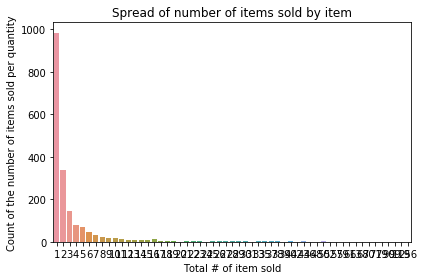

In [41]:
# Find a threshhold below-which it makes sense to drop
sns.countplot(item_count)
plt.title('Spread of number of items sold by item')
plt.xlabel('Total # of item sold')
plt.ylabel('Count of the number of items sold per quantity')

plt.tight_layout()
plt.savefig('figures/item_countplot.png')

From the above plot, there are lots of items that only sold once. Those we don't necessarily want, but this doesn't give us any clear "cut off" point. Let's cut off items only sold once at this point.

In [71]:
# Drop items only sold once
item_count = item_count[item_count['num_times_sold']>1]

In [74]:
# Drop 'Rental' and 'Misc Hardware'
item_count.drop(['RENTAL','MISCELLANEOUS HARDWARE'], inplace=True)

num_times_sold
description                                   
MOTO CP200D 403-470 4W ND                  119
MOTO XPR 3300E 403-512 4W                   99
SOS INTERSECTOR UNDER MIRROR                90
CODE3 T-REX LED LIGHTS                      71
UNICATION G5 DUAL BAND PAGER                70
MOTO MIN VI PAGER VHF 143-174               68
ANTENNA/ MOBILE 806-900 MHZ                 63
MOTO CP200D UHF 4W ND                       61
LIION BATTERY 2190 MAH                      59
SPECTRUM MAGNETIC MNT  MINIUHF              57

### Use that list of items to drop from original data list

In [78]:
# Make a list of the items to keep (the index from item_count)
keep_list = list(item_count.index)

# Use that to filter the data df and keep only those items (description isin list)
data = data[data['description'].isin(keep_list)]
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6559 entries, ('1HOLPS', Timestamp('2015-05-08 00:00:00')) to ('4LAKEL', Timestamp('2020-09-30 00:00:00'))
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   qty_shipped         6559 non-null   float64
 1   item                6559 non-null   object 
 2   description         6559 non-null   object 
 3   item_price          6559 non-null   float64
 4   industry            6559 non-null   object 
 5   contact_owner       6559 non-null   object 
 6   lifetime_sales      6559 non-null   float64
 7   first_sale          6559 non-null   object 
 8   county              6559 non-null   object 
 9   market_opportunity  6559 non-null   float64
 10  %_market_opp        6559 non-null   float64
dtypes: float64(5), object(6)
memory usage: 595.4+ KB


### Use this updated list to calculate and rank items by average price

In [83]:
items = data.groupby('description')['item_price'].mean().to_frame()
items.columns = ['avg_sale_price']
items.sort_values('avg_sale_price', ascending=False, inplace=True)

# Create top lists for examination
top_25 = items.head(25)
top_50 = items.head(50)
top_100 = items.head(100)

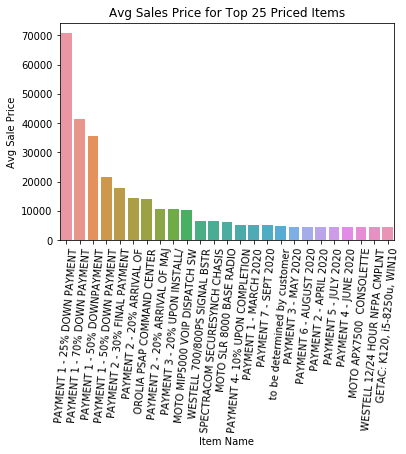

In [88]:
# Plot the top 25 list
sns.barplot(x=top_25.index, y=top_25.avg_sale_price)
plt.title('Avg Sales Price for Top 25 Priced Items')
plt.ylabel('Avg Sale Price')
plt.xticks(rotation=85)
plt.xlabel('Item Name')

plt.savefig('figures/top25_items.png')

#### Drop "Payment" items
These payment items are almost all the highest priced items and throw things off significantly. Drop anything with "payment" in the name"

In [115]:
### Drop any item with "payment" in the name
items.reset_index(inplace=True)

items = items[~items['description'].str.contains('PAYMENT')]
items.set_index('description', inplace=True)
items.head()

# Create top lists for examination
top_25 = items.head(25)
top_50 = items.head(50)

ValueError: cannot insert level_0, already exists

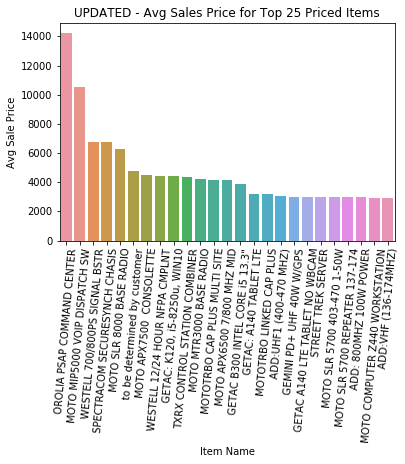

In [96]:
# Plot the top 25 list
sns.barplot(x=top_25.index, y=top_25.avg_sale_price)
plt.title('UPDATED - Avg Sales Price for Top 25 Priced Items')
plt.ylabel('Avg Sale Price')
plt.xticks(rotation=85)
plt.xlabel('Item Name')

plt.savefig('figures/top25_items_no_payment_plans.png')

In [ ]:
# Cleanup my columns
items.drop(['level_0','index'], inplace=True, axis=1)

In [109]:
# Create a new column that is the item rank
items.reset_index(inplace=True)
items['item_price_rank'] = [i+1 for i in items.index]
items.head()

level_0  index                    description  avg_sale_price  \
0        0      0     OROLIA PSAP COMMAND CENTER    14200.000000   
1        1      1  MOTO MIP5000 VOIP DISPATCH SW    10500.000000   
2        2      2  WESTELL 700/800PS SIGNAL BSTR     6749.500000   
3        3      3  SPECTRACOM SECURESYNCH CHASIS     6743.000000   
4        4      4       MOTO SLR 8000 BASE RADIO     6298.029167   

   item_price_rank  
0                1  
1                2  
2                3  
3                4  
4                5

#### Drop really low priced items too

How to define "really low?"

In [124]:
items.tail(200)

level_0  index                     description  avg_sale_price  \
694      694    694   MOTO 2-WIRE TRANS TUBE, BLACK       39.016667   
695      695    695    MOTO SURV. EARPIECE, IN-LINE       38.571429   
696      696    696  MOTO COMPACT MICROPHONE W/CLIP       38.400000   
697      697    697            OPERATOR 1 3/4" BELT       38.323333   
698      698    698                    COMPANY PANT       38.000000   
..       ...    ...                             ...             ...   
889      889    889      ANDREW 1/4 SUPERFLEX CABLE        1.785714   
890      890    890           LMR400 COAX RG8 CABLE        1.662500   
891      891    891     #6 STRANDED INSUL GRND WIRE        1.433333   
892      892    892          #6 1 HOLE, 1/4", SHORT        1.050000   
893      893    893                      CAT5 CABLE        0.600000   

     item_price_rank  
694              695  
695              696  
696              697  
697              698  
698              699  
..               ...  
889              890  
890              891  
891              892  
892              893  
893              894  

[200 rows x 5 columns]

The last 200 items are still largely accessories - all priced under $40. That seems like a good enough threshold for now. We can always adjust this later.

In [125]:
# Drop all items priced under $40
items = items[items['avg_sale_price']>40]
items.tail()

level_0  index                  description  avg_sale_price  \
672      672    672  UNICATION EXTENDED WARRANTY           42.25   
673      673    673           COMPANY CARGO PANT           42.00   
674      674    674        CABLE, MOBILE MIC EXT           42.00   
675      675    675      N MALE FOR 1/4 FLEX HF-           41.20   
676      676    676        MOTO BATT LIION 2300T           41.00   

     item_price_rank  
672              673  
673              674  
674              675  
675              676  
676              677

### 4.2.2 Keep only the items left in original dataframe

In [126]:
keep_list = list(items.description.unique())
data = data[data['description'].isin(keep_list)]
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5144 entries, ('1HOLPS', Timestamp('2015-05-08 00:00:00')) to ('4MICPD', Timestamp('2020-09-30 00:00:00'))
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   qty_shipped         5144 non-null   float64
 1   item                5144 non-null   object 
 2   description         5144 non-null   object 
 3   item_price          5144 non-null   float64
 4   industry            5144 non-null   object 
 5   contact_owner       5144 non-null   object 
 6   lifetime_sales      5144 non-null   float64
 7   first_sale          5144 non-null   object 
 8   county              5144 non-null   object 
 9   market_opportunity  5144 non-null   float64
 10  %_market_opp        5144 non-null   float64
dtypes: float64(5), object(6)
memory usage: 468.3+ KB


### 4.2.3 Join the item_price_rank with data df


In [134]:
### LEFT OFF HERE - join the ranking of items by price back with original data df

## 4.3 Drop all but highest priced item for each sale date

Each row of my final data frame will represent the highest ranked item purchased on that sale date by that customer

In [6]:
# Drop all but the highest priced item for each sale date

    # We can loop through and create a list of all the index numbers to save
    # Then use .iloc to save only those rows to a new dataframe

rows_to_keep = []
    
for i, (x,y) in enumerate(data.index):

7890

In [21]:
for i, (x,y) in enumerate(data.index):
    print(i,x,y)

1 1HOLPS 2015-05-08 00:00:00
1 1VANAI 2015-04-17 00:00:00
1 1VANAI 2015-04-17 00:00:00
1 1VANAI 2015-04-17 00:00:00
1 1VANAI 2015-04-17 00:00:00
1 1HAWOR 2015-01-30 00:00:00
1 1POKPP 2015-03-13 00:00:00
1 1POKPP 2015-03-13 00:00:00
1 1POKPP 2015-03-13 00:00:00
1 1POKPP 2015-03-13 00:00:00
1 1POKPP 2015-03-13 00:00:00
1 1POKPP 2015-03-13 00:00:00
1 1POKPP 2015-03-13 00:00:00
1 1POKPP 2015-03-13 00:00:00
1 1POKPP 2015-03-13 00:00:00
1 1POKPP 2015-03-13 00:00:00
1 1POKPP 2015-03-13 00:00:00
1 1POKPP 2015-03-13 00:00:00
1 1POKPP 2015-03-13 00:00:00
1 1POKPP 2015-03-13 00:00:00
1 1POKPP 2015-03-13 00:00:00
1 1POKPP 2015-03-13 00:00:00
1 1POKPP 2015-03-13 00:00:00
1 1POKPP 2015-03-13 00:00:00
1 1EATSD 2015-03-06 00:00:00
1 1EATSD 2015-03-06 00:00:00
1 1POKPP 2015-03-13 00:00:00
1 1POKPP 2015-03-13 00:00:00
1 4BERSH 2015-01-23 00:00:00
1 4BERSH 2015-01-23 00:00:00
1 4SOUHC 2015-03-27 00:00:00
1 4SOUHC 2015-03-27 00:00:00
1 4SOUHC 2015-03-27 00:00:00
1 4SOUHC 2015-03-27 00:00:00
1 4SOUHC 2015-

1 1AVOAU 2015-04-17 00:00:00
1 1AVOAU 2015-04-17 00:00:00
1 1AVOAU 2015-04-17 00:00:00
1 1OTSEG 2015-04-17 00:00:00
1 1AVOAU 2015-04-17 00:00:00
1 1AVOAU 2015-04-17 00:00:00
1 1AVOAU 2015-04-17 00:00:00
1 1PADNI 2015-03-31 00:00:00
1 1GRHAT 2015-04-14 00:00:00
1 1STEEL 2015-04-17 00:00:00
1 1GORFO 2015-07-31 00:00:00
1 1ZEEFD 2015-04-14 00:00:00
1 1HMEMA 2015-04-17 00:00:00
1 4BERSH 2015-08-28 00:00:00
1 4BERSH 2015-08-28 00:00:00
1 4BERSH 2015-08-28 00:00:00
1 4BERSH 2015-08-07 00:00:00
1 4BERSH 2015-06-19 00:00:00
1 4BERSH 2015-05-29 00:00:00
1 4BERSH 2015-05-08 00:00:00
1 4BERSH 2015-05-15 00:00:00
1 4BERSH 2015-05-22 00:00:00
1 1MASFL 2015-04-17 00:00:00
1 1MASFL 2015-04-17 00:00:00
1 1MASFL 2015-04-17 00:00:00
1 1FENFD 2015-04-02 00:00:00
1 1FENFD 2015-04-02 00:00:00
1 1DOWAG 2015-06-19 00:00:00
1 1DOWAG 2015-06-19 00:00:00
1 1DOWAG 2015-06-19 00:00:00
1 1DOWAG 2015-06-19 00:00:00
1 1DOWAG 2015-06-19 00:00:00
1 1DOWAG 2015-06-19 00:00:00
1 1DOWAG 2015-06-19 00:00:00
1 1DOWAG 2015-

1 1ROSCA 2015-09-25 00:00:00
1 1ROSCA 2015-09-25 00:00:00
1 1ROSCA 2015-09-25 00:00:00
1 7CCECD 2015-09-22 00:00:00
1 7CCECD 2015-09-22 00:00:00
1 1NBFAS 2015-10-23 00:00:00
1 1BYTFD 2016-06-24 00:00:00
1 4RIVTP 2015-10-23 00:00:00
1 4SOUPD 2015-11-06 00:00:00
1 4SOUPD 2015-11-06 00:00:00
1 1COLQF 2015-10-09 00:00:00
1 1COLQF 2015-10-09 00:00:00
1 1COLQF 2015-10-09 00:00:00
1 7CCECD 2015-09-30 00:00:00
1 7CCECD 2015-09-30 00:00:00
1 1KENPA 2015-10-16 00:00:00
1 1MANCD 2015-09-25 00:00:00
1 7MANDE 2015-11-13 00:00:00
1 7MANDE 2015-11-13 00:00:00
1 7MANDE 2015-11-13 00:00:00
1 7MANDE 2015-11-13 00:00:00
1 1ROBTF 2015-10-09 00:00:00
1 1SUNAE 2015-10-07 00:00:00
1 4SOUPD 2015-11-06 00:00:00
1 1NBFAS 2015-10-23 00:00:00
1 1MERAM 2015-10-30 00:00:00
1 1MERAM 2015-10-30 00:00:00
1 1MERAM 2015-10-30 00:00:00
1 1MERAM 2015-10-30 00:00:00
1 1MERAM 2015-10-30 00:00:00
1 1MERAM 2015-10-30 00:00:00
1 1SCHIP 2015-10-09 00:00:00
1 1SCHIP 2015-10-09 00:00:00
1 1NEWCJ 2015-10-23 00:00:00
1 7CCECD 2015-

1 1POKPP 2016-06-30 00:00:00
1 1POKPP 2016-06-30 00:00:00
1 1POKPP 2016-06-30 00:00:00
1 1POKPP 2016-06-30 00:00:00
1 1POKPP 2016-06-30 00:00:00
1 1POKPP 2016-06-30 00:00:00
1 1POKPP 2016-06-30 00:00:00
1 1POKPP 2016-06-30 00:00:00
1 1EATSD 2016-02-29 00:00:00
1 1LEECS 2016-03-11 00:00:00
1 7EMSHR 2016-03-31 00:00:00
1 7EMSHR 2016-03-31 00:00:00
1 1POKPP 2016-03-11 00:00:00
1 1POKPP 2016-03-11 00:00:00
1 1POKPP 2016-06-30 00:00:00
1 1POKPP 2016-06-30 00:00:00
1 1MOTUS 2016-02-29 00:00:00
1 1WETEC 2016-03-11 00:00:00
1 1WETEC 2016-03-11 00:00:00
1 1ZEEFS 2016-02-29 00:00:00
1 1HAWOR 2016-02-29 00:00:00
1 1BUTSE 2016-03-11 00:00:00
1 1BUTSE 2016-03-11 00:00:00
1 7HARSP 2016-03-11 00:00:00
1 7HARSP 2016-03-11 00:00:00
1 7HARSP 2016-03-11 00:00:00
1 7HARSP 2016-03-11 00:00:00
1 7HARSP 2016-03-11 00:00:00
1 1AVOAU 2016-03-11 00:00:00
1 1AVOAU 2016-03-11 00:00:00
1 1AVOAU 2016-03-11 00:00:00
1 1AVOAU 2016-03-11 00:00:00
1 1OLITO 2016-03-11 00:00:00
1 1OLITO 2016-03-11 00:00:00
1 1OLITO 2016-

1 4BENPD 2016-08-19 00:00:00
1 4BENPD 2016-08-19 00:00:00
1 4BENPD 2016-08-19 00:00:00
1 4BENPD 2016-08-19 00:00:00
1 4BENPD 2016-08-19 00:00:00
1 4BENPD 2016-08-19 00:00:00
1 4BENPD 2016-08-19 00:00:00
1 4BENPD 2016-08-19 00:00:00
1 4BENPD 2016-08-19 00:00:00
1 1HOLPS 2016-05-13 00:00:00
1 1GENTX 2016-11-22 00:00:00
1 1DAVEN 2016-06-24 00:00:00
1 1DAVEN 2016-06-24 00:00:00
1 1DAVEN 2016-06-24 00:00:00
1 1DAVEN 2016-06-24 00:00:00
1 1DAVEN 2016-06-24 00:00:00
1 7CCECD 2016-04-29 00:00:00
1 1KEEBL 2016-05-20 00:00:00
1 1KEEBL 2016-05-20 00:00:00
1 1KEEBL 2016-05-20 00:00:00
1 1KEEBL 2016-05-20 00:00:00
1 7BOYPO 2016-05-20 00:00:00
1 7MUNME 2016-12-31 00:00:00
1 7MUNME 2016-12-31 00:00:00
1 7MUNME 2016-12-31 00:00:00
1 7MUNME 2016-12-31 00:00:00
1 7MUNME 2016-12-31 00:00:00
1 7MUNME 2016-12-31 00:00:00
1 7MUNME 2016-12-31 00:00:00
1 7MUNME 2016-12-31 00:00:00
1 7MUNME 2016-12-31 00:00:00
1 7MUNME 2016-12-31 00:00:00
1 7MUNME 2016-12-31 00:00:00
1 7MUNME 2016-12-31 00:00:00
1 7MUNME 2016-

1 1POKPP 2016-11-11 00:00:00
1 1POKPP 2016-11-11 00:00:00
1 1POKPP 2016-11-11 00:00:00
1 1POKPP 2016-11-11 00:00:00
1 1POKPP 2016-11-11 00:00:00
1 1POKPP 2016-11-11 00:00:00
1 1POKPP 2016-11-11 00:00:00
1 1POKPP 2016-11-11 00:00:00
1 1POKPP 2016-11-11 00:00:00
1 1POKPP 2016-11-11 00:00:00
1 1POKPP 2016-11-11 00:00:00
1 1POKPP 2016-11-11 00:00:00
1 1POKPP 2016-11-11 00:00:00
1 1POKPP 2016-11-11 00:00:00
1 1POKPP 2016-11-11 00:00:00
1 1POKPP 2016-11-11 00:00:00
1 1POKPP 2016-11-11 00:00:00
1 1POKPP 2016-11-11 00:00:00
1 1POKPP 2016-11-11 00:00:00
1 1POKPP 2016-11-11 00:00:00
1 1POKPP 2016-11-11 00:00:00
1 1BUTSE 2016-07-29 00:00:00
1 1BUTSE 2016-07-29 00:00:00
1 1BUTSE 2016-07-29 00:00:00
1 4COVPD 2016-10-28 00:00:00
1 4COVPD 2016-10-28 00:00:00
1 4COVPD 2016-10-28 00:00:00
1 4COVPD 2016-10-28 00:00:00
1 4COVPD 2016-10-28 00:00:00
1 4COVPD 2016-10-28 00:00:00
1 4COVPD 2016-10-28 00:00:00
1 4COVPD 2016-10-28 00:00:00
1 4COVPD 2016-10-28 00:00:00
1 4COVPD 2016-10-28 00:00:00
1 4COVPD 2016-

1 1GENTX 2016-11-22 00:00:00
1 1MANCD 2016-09-30 00:00:00
1 1MANCD 2016-09-30 00:00:00
1 1LITIN 2016-10-28 00:00:00
1 1LITIN 2016-10-28 00:00:00
1 1MANCD 2017-09-28 00:00:00
1 1KEEBL 2016-10-21 00:00:00
1 1KEEBL 2016-10-21 00:00:00
1 1KEEBL 2016-10-21 00:00:00
1 1KEEBL 2016-10-21 00:00:00
1 1KEEBL 2016-10-21 00:00:00
1 1KEEBL 2016-10-21 00:00:00
1 1LITIN 2016-12-30 00:00:00
1 1LITIN 2016-12-30 00:00:00
1 1GRTFD 2016-10-21 00:00:00
1 1HOLGA 2016-11-30 00:00:00
1 1HOLGA 2016-11-30 00:00:00
1 1HOLGA 2016-11-30 00:00:00
1 1MANCD 2017-09-28 00:00:00
1 1MANCD 2016-09-29 00:00:00
1 1LITIN 2016-10-28 00:00:00
1 1LITIN 2016-10-28 00:00:00
1 1LITIN 2016-10-28 00:00:00
1 1LITIN 2016-10-28 00:00:00
1 1LITIN 2016-10-28 00:00:00
1 1MANCD 2016-09-30 00:00:00
1 1MANCD 2016-09-30 00:00:00
1 1MANCD 2016-09-30 00:00:00
1 1MANCD 2016-09-30 00:00:00
1 1MANCD 2016-09-30 00:00:00
1 7MUNME 2016-12-31 00:00:00
1 7MUNME 2016-12-31 00:00:00
1 7MUNME 2016-12-31 00:00:00
1 7MUNME 2016-12-31 00:00:00
1 1HOLDA 2016-

1 1POKPP 2017-03-10 00:00:00
1 1POKPP 2017-03-10 00:00:00
1 7MISCS 2017-02-24 00:00:00
1 1GNSAM 2017-02-24 00:00:00
1 1GNSAM 2017-02-24 00:00:00
1 1PRIDG 2017-04-07 00:00:00
1 1PRIDG 2017-04-07 00:00:00
1 1PRIDG 2017-04-07 00:00:00
1 1DAVEN 2017-06-29 00:00:00
1 1DAVEN 2017-06-29 00:00:00
1 1DAVEN 2017-06-29 00:00:00
1 1DAVEN 2017-06-29 00:00:00
1 1DAVEN 2017-06-29 00:00:00
1 1MAGNA 2017-02-24 00:00:00
1 1MAGNA 2017-02-24 00:00:00
1 1DAVEN 2017-06-29 00:00:00
1 1DAVEN 2017-06-29 00:00:00
1 1DAVEN 2017-06-29 00:00:00
1 1DAVEN 2017-06-29 00:00:00
1 1DAVEN 2017-06-29 00:00:00
1 1AMWAY 2017-02-28 00:00:00
1 7EMAMB 2017-02-10 00:00:00
1 1KRUCO 2017-03-17 00:00:00
1 1KRUCO 2017-03-17 00:00:00
1 1HOLBP 2017-02-24 00:00:00
1 1HOLBP 2017-02-24 00:00:00
1 7EMAMB 2017-02-24 00:00:00
1 1ROSCA 2017-02-24 00:00:00
1 1ROSCA 2017-02-24 00:00:00
1 1POKPP 2017-03-03 00:00:00
1 1VANAI 2017-04-21 00:00:00
1 1ROYTO 2017-06-20 00:00:00
1 1ROYTO 2017-06-20 00:00:00
1 1ROYTO 2017-06-20 00:00:00
1 7MARMA 2017-

1 1NUGEN 2017-06-29 00:00:00
1 1AVOAU 2017-05-31 00:00:00
1 1AVOAU 2017-05-31 00:00:00
1 1AVOAU 2017-05-31 00:00:00
1 1ROSCA 2017-04-28 00:00:00
1 1ROSCA 2017-05-12 00:00:00
1 1NUGEN 2017-06-29 00:00:00
1 1GORFO 2017-05-12 00:00:00
1 1NORAI 2017-05-12 00:00:00
1 1NORAI 2017-05-12 00:00:00
1 1ARCBG 2017-05-19 00:00:00
1 1AVOAU 2017-05-05 00:00:00
1 1AVOAU 2017-05-05 00:00:00
1 1AVOAU 2017-05-05 00:00:00
1 1OTSEG 2017-05-31 00:00:00
1 1OTSEG 2017-05-31 00:00:00
1 1OTSEG 2017-05-31 00:00:00
1 1MAGEG 2017-06-02 00:00:00
1 1MASFL 2017-05-12 00:00:00
1 1RICOR 2017-05-12 00:00:00
1 4CHTPD 2017-07-28 00:00:00
1 4BARPD 2017-08-31 00:00:00
1 1OTMEM 2017-09-29 00:00:00
1 4BERSH 2017-06-20 00:00:00
1 4STJOS 2017-05-26 00:00:00
1 1WATPD 2017-05-12 00:00:00
1 1WATPD 2017-05-12 00:00:00
1 1STEEL 2017-05-19 00:00:00
1 1STEEL 2017-05-19 00:00:00
1 4STJOS 2017-05-26 00:00:00
1 1HERMI 2017-05-26 00:00:00
1 1HOLSD 2017-05-31 00:00:00
1 1POKPP 2017-07-28 00:00:00
1 1POKPP 2017-07-28 00:00:00
1 1POKPP 2017-

1 1CASSC 2017-11-22 00:00:00
1 1OTMEM 2017-09-29 00:00:00
1 1ALTWN 2017-12-22 00:00:00
1 1VANPT 2017-11-22 00:00:00
1 1VANPT 2017-11-22 00:00:00
1 1VANPT 2017-11-22 00:00:00
1 1ALTWN 2017-12-22 00:00:00
1 1VANPT 2017-11-22 00:00:00
1 1VANPT 2017-11-22 00:00:00
1 1VANPT 2017-11-22 00:00:00
1 1VANPT 2017-11-22 00:00:00
1 1VANPT 2017-11-22 00:00:00
1 1VANPT 2017-11-22 00:00:00
1 1VANPT 2017-11-22 00:00:00
1 1VANPT 2017-11-22 00:00:00
1 1VANPT 2017-11-22 00:00:00
1 1VANPT 2017-11-22 00:00:00
1 1VANPT 2017-11-22 00:00:00
1 1VANPT 2017-11-22 00:00:00
1 1VANPT 2017-11-22 00:00:00
1 1VANPT 2017-11-22 00:00:00
1 1VANPT 2017-11-22 00:00:00
1 1VANPT 2017-11-22 00:00:00
1 1VANPT 2017-11-22 00:00:00
1 1VANPT 2017-11-22 00:00:00
1 1VANPT 2017-11-22 00:00:00
1 1VANPT 2017-11-22 00:00:00
1 1VANPT 2017-11-22 00:00:00
1 1HILIT 2017-10-06 00:00:00
1 1HILIT 2017-10-06 00:00:00
1 1HILIT 2017-10-06 00:00:00
1 4NEWPD 2017-11-22 00:00:00
1 1WMSPC 2017-10-20 00:00:00
1 1KEEBL 2017-10-31 00:00:00
1 4STJOS 2017-

1 4BERSH 2018-08-10 00:00:00
1 4BERSH 2018-06-22 00:00:00
1 1OCECR 2018-03-29 00:00:00
1 1OCECR 2018-03-29 00:00:00
1 1NOOCH 2018-05-04 00:00:00
1 4BERSH 2018-06-29 00:00:00
1 4BERSH 2018-06-29 00:00:00
1 4BERSH 2018-06-29 00:00:00
1 4BERSH 2018-06-29 00:00:00
1 4BERSH 2018-06-29 00:00:00
1 1POKPP 2018-02-21 00:00:00
1 1POKPP 2018-02-21 00:00:00
1 1HOLDA 2018-03-23 00:00:00
1 1BRADF 2018-03-09 00:00:00
1 1SUNMA 2018-03-23 00:00:00
1 1SUNMA 2018-03-23 00:00:00
1 1SUNMA 2018-03-23 00:00:00
1 1FRECO 2018-02-23 00:00:00
1 7MISCR 2018-02-28 00:00:00
1 1QCQFD 2018-03-16 00:00:00
1 1STOWC 2018-06-29 00:00:00
1 1STOWC 2018-06-29 00:00:00
1 1STOWC 2018-06-29 00:00:00
1 1STOWC 2018-06-29 00:00:00
1 1STOWC 2018-06-29 00:00:00
1 1WCBCH 2018-07-18 00:00:00
1 1WCBCH 2018-07-18 00:00:00
1 1CIRCC 2018-05-25 00:00:00
1 1CIRCC 2018-05-25 00:00:00
1 1CIRCC 2018-05-25 00:00:00
1 1CIRCC 2018-05-25 00:00:00
1 4FERMI 2018-03-16 00:00:00
1 1KAMPS 2018-03-23 00:00:00
1 1KAMPS 2018-03-23 00:00:00
1 1KAMPS 2018-

1 1AVOAU 2018-06-29 00:00:00
1 1AVOAU 2018-06-29 00:00:00
1 1HOLSD 2018-06-22 00:00:00
1 1COORE 2018-07-18 00:00:00
1 3GRANF 2018-09-25 00:00:00
1 1MEAGC 2018-06-22 00:00:00
1 1GUAPR 2018-10-24 00:00:00
1 1GUAPR 2018-10-24 00:00:00
1 1GUAPR 2018-10-24 00:00:00
1 1GUAPR 2018-10-24 00:00:00
1 1MAGNA 2018-06-27 00:00:00
1 1WCBCH 2018-07-18 00:00:00
1 1FCSTJ 2018-06-21 00:00:00
1 1OTSEG 2018-06-29 00:00:00
1 4LINTP 2018-07-20 00:00:00
1 7REDPO 2018-06-29 00:00:00
1 4STJOS 2018-06-29 00:00:00
1 4LINTP 2018-07-20 00:00:00
1 4LINTP 2018-07-20 00:00:00
1 1FCSTJ 2018-06-21 00:00:00
1 1KENQF 2018-07-06 00:00:00
1 1KENQF 2018-07-06 00:00:00
1 1KENQF 2018-07-06 00:00:00
1 1KAMPS 2018-07-06 00:00:00
1 1MSUBI 2018-06-29 00:00:00
1 1MSUBI 2018-06-29 00:00:00
1 1ARCBG 2018-07-18 00:00:00
1 1MAGEG 2018-06-29 00:00:00
1 1MAGEG 2018-06-29 00:00:00
1 1SYSFO 2018-07-18 00:00:00
1 1SYSFO 2018-07-18 00:00:00
1 1TURLC 2018-07-06 00:00:00
1 4BERSH 2018-06-27 00:00:00
1 1ZEEPD 2018-09-07 00:00:00
1 1ZEEPD 2018-

1 1SUNMA 2018-09-18 00:00:00
1 1OTISD 2018-10-31 00:00:00
1 1GEOTF 2018-09-18 00:00:00
1 1NBFAS 2018-10-09 00:00:00
1 3GRANF 2018-09-25 00:00:00
1 1MAGEG 2018-11-09 00:00:00
1 1MAGEG 2018-11-09 00:00:00
1 1HILIT 2018-09-28 00:00:00
1 1HILIT 2018-09-28 00:00:00
1 1HILIT 2018-09-28 00:00:00
1 7LTBBO 2018-10-26 00:00:00
1 7LTBBO 2018-10-26 00:00:00
1 1GEOSC 2018-10-17 00:00:00
1 1GEOSC 2018-10-17 00:00:00
1 1FRECO 2018-10-17 00:00:00
1 1FRECO 2018-10-17 00:00:00
1 1WOOMA 2018-09-11 00:00:00
1 1WOOMA 2018-09-11 00:00:00
1 1PERRI 2018-09-18 00:00:00
1 4BERSH 2018-09-28 00:00:00
1 1PARTO 2018-09-28 00:00:00
1 1PARTO 2018-09-28 00:00:00
1 1PARTO 2018-09-28 00:00:00
1 1COORI 2018-10-17 00:00:00
1 1SAUGA 2018-10-24 00:00:00
1 1TURLC 2018-09-28 00:00:00
1 1CIRCC 2018-10-09 00:00:00
1 1HOLBP 2018-10-17 00:00:00
1 1HOLBP 2018-10-17 00:00:00
1 4LAKTW 2018-09-20 00:00:00
1 1MOTUS 2018-09-25 00:00:00
1 1TURLC 2018-10-09 00:00:00
1 7CADUT 2019-01-18 00:00:00
1 7CADUT 2019-01-18 00:00:00
1 7CADUT 2019-

1 1HOLCS 2019-06-11 00:00:00
1 1HOLCS 2019-06-11 00:00:00
1 1HOLCS 2019-06-11 00:00:00
1 1HOLCS 2019-06-11 00:00:00
1 1HOLCS 2019-06-11 00:00:00
1 1KENCA 2018-12-27 00:00:00
1 1HOLCS 2018-12-27 00:00:00
1 4STJOS 2018-12-27 00:00:00
1 4STJOS 2018-12-27 00:00:00
1 4STJOS 2018-12-27 00:00:00
1 1KEEBL 2019-01-18 00:00:00
1 7INVFD 2019-02-07 00:00:00
1 1FOURW 2018-12-28 00:00:00
1 1FOURW 2018-12-28 00:00:00
1 1KEEBL 2019-01-18 00:00:00
1 1HOLTF 2018-12-31 00:00:00
1 4NEWPD 2018-12-31 00:00:00
1 4NEWPD 2018-12-31 00:00:00
1 4NEWPD 2018-12-31 00:00:00
1 1FOURW 2019-02-15 00:00:00
1 1AVOAU 2019-02-07 00:00:00
1 1GTPAV 2019-02-07 00:00:00
1 1GTPAV 2019-02-07 00:00:00
1 1SUNMA 2019-02-07 00:00:00
1 4NEWPD 2019-03-22 00:00:00
1 4LINTP 2019-02-15 00:00:00
1 1CASSC 2019-08-29 00:00:00
1 1CASSC 2019-08-29 00:00:00
1 1STEEL 2019-03-14 00:00:00
1 1STEEL 2019-03-14 00:00:00
1 1HOLTF 2019-01-10 00:00:00
1 1AVOAU 2019-02-07 00:00:00
1 1AVOAU 2019-02-07 00:00:00
1 1AVOAU 2019-02-07 00:00:00
1 1DEHGR 2019-

1 7NMHOS 2019-06-28 00:00:00
1 7NMHOS 2019-06-28 00:00:00
1 7NMHOS 2019-06-28 00:00:00
1 7NMHOS 2019-06-28 00:00:00
1 7NMHOS 2019-06-28 00:00:00
1 1YOULP 2019-06-14 00:00:00
1 1HOPFD 2019-05-24 00:00:00
1 1CMPSU 2019-06-27 00:00:00
1 1ZEEFD 2019-05-30 00:00:00
1 1OCECR 2019-06-14 00:00:00
1 1OCECR 2019-06-14 00:00:00
1 1OCECR 2019-06-14 00:00:00
1 1CASSC 2019-08-29 00:00:00
1 1CASSC 2019-08-29 00:00:00
1 1CASSC 2019-08-29 00:00:00
1 1CONCI 2019-06-14 00:00:00
1 1KEEBL 2019-06-14 00:00:00
1 1KAMPS 2019-06-27 00:00:00
1 1ZFSIT 2019-06-27 00:00:00
1 1ZFSIT 2019-08-29 00:00:00
1 1ZFSIT 2019-08-29 00:00:00
1 1HOLBP 2019-10-31 00:00:00
1 1HOLBP 2019-10-31 00:00:00
1 1OTISD 2019-07-31 00:00:00
1 1OTISD 2019-07-31 00:00:00
1 1EAGAI 2019-06-28 00:00:00
1 1EAGAI 2019-06-28 00:00:00
1 1EAGAI 2019-06-28 00:00:00
1 1EAGAI 2019-06-28 00:00:00
1 1EAGAI 2019-06-28 00:00:00
1 1EAGAI 2019-06-28 00:00:00
1 1EAGAI 2019-06-28 00:00:00
1 1EAGAI 2019-06-28 00:00:00
1 1EAGAI 2019-06-28 00:00:00
1 1EAGAI 2019-

1 1GUNFD 2019-10-31 00:00:00
1 1OTISD 2020-02-28 00:00:00
1 1OTISD 2020-02-28 00:00:00
1 1CHECS 2019-11-27 00:00:00
1 1REAFD 2019-12-20 00:00:00
1 1REAFD 2019-12-20 00:00:00
1 1REAFD 2019-12-20 00:00:00
1 1REAFD 2019-12-20 00:00:00
1 1REAFD 2019-12-20 00:00:00
1 1HOLPS 2019-11-22 00:00:00
1 1LIGEC 2019-11-08 00:00:00
1 1LIGEC 2019-11-08 00:00:00
1 1FOURW 2019-10-25 00:00:00
1 1FOURW 2019-10-25 00:00:00
1 1REAFD 2019-12-20 00:00:00
1 1FOURW 2019-12-31 00:00:00
1 1VANAI 2019-11-15 00:00:00
1 7ECRDC 2019-11-27 00:00:00
1 7ECRDC 2019-11-27 00:00:00
1 7ECRDC 2019-11-27 00:00:00
1 1YATDI 2019-10-31 00:00:00
1 1WMISP 2019-10-30 00:00:00
1 1WMISP 2019-10-30 00:00:00
1 1PERRI 2019-11-15 00:00:00
1 1BISSE 2019-10-31 00:00:00
1 1HOLSD 2019-11-08 00:00:00
1 1CHECS 2019-11-27 00:00:00
1 1CHECS 2019-11-30 00:00:00
1 1BISSE 2019-10-31 00:00:00
1 1PLEMM 2019-11-27 00:00:00
1 1PLEMM 2019-11-27 00:00:00
1 7FIVCA 2019-10-31 00:00:00
1 7INLLA 2019-10-31 00:00:00
1 7CHEEL 2019-10-31 00:00:00
1 4NEWPD 2019-

1 1ZEEFS 2020-02-19 00:00:00
1 1WESOS 2020-02-19 00:00:00
1 4WYCCH 2020-01-31 00:00:00
1 4WYCCH 2020-01-31 00:00:00
1 4WYCCH 2020-01-31 00:00:00
1 1BRADF 2020-01-31 00:00:00
1 1KEEBL 2020-01-31 00:00:00
1 1ZFSIT 2020-02-19 00:00:00
1 1ZFSIT 2020-02-19 00:00:00
1 1ZFSIT 2020-02-19 00:00:00
1 1ZFSIT 2020-02-19 00:00:00
1 1KENQF 2020-02-19 00:00:00
1 1SMGDV 2020-01-23 00:00:00
1 1SMGDV 2020-01-23 00:00:00
1 1SMGDV 2020-01-23 00:00:00
1 1SMGDV 2020-01-23 00:00:00
1 1SMGDV 2020-01-23 00:00:00
1 1SMGDV 2020-01-23 00:00:00
1 1ZEEPS 2020-01-23 00:00:00
1 1OLITO 2020-01-31 00:00:00
1 1YATDI 2020-01-24 00:00:00
1 1YATDI 2020-01-24 00:00:00
1 1YATDI 2020-01-24 00:00:00
1 1YATDI 2020-01-24 00:00:00
1 1YATDI 2020-01-24 00:00:00
1 1YATDI 2020-01-24 00:00:00
1 1NBFAS 2020-01-24 00:00:00
1 1FOURW 2020-02-19 00:00:00
1 1HOWMC 2020-02-21 00:00:00
1 1HOWMC 2020-02-21 00:00:00
1 1JAMES 2020-02-19 00:00:00
1 1JAMES 2020-02-19 00:00:00
1 1KAMPS 2020-02-28 00:00:00
1 1KAMPS 2020-02-28 00:00:00
1 1OTSEG 2020-

1 7PETFD 2020-07-10 00:00:00
1 7PETFD 2020-07-10 00:00:00
1 7PETFD 2020-07-10 00:00:00
1 7PETFD 2020-07-10 00:00:00
1 1KENQF 2020-06-30 00:00:00
1 4MICPD 2020-09-30 00:00:00
1 4MICPD 2020-09-30 00:00:00
1 4MICPD 2020-09-30 00:00:00
1 4BERSH 2020-05-29 00:00:00
1 4BERSH 2020-05-29 00:00:00
1 4BERSH 2020-05-29 00:00:00
1 4BERSH 2020-05-29 00:00:00
1 4BERSH 2020-05-29 00:00:00
1 4BERSH 2020-05-29 00:00:00
1 4BERSH 2020-05-29 00:00:00
1 1ZFSIT 2020-06-05 00:00:00
1 4WYCCH 2020-06-30 00:00:00
1 4WYCCH 2020-06-30 00:00:00
1 4WYCCH 2020-06-30 00:00:00
1 4WYCCH 2020-06-30 00:00:00
1 4WYCCH 2020-06-30 00:00:00
1 4MICPD 2020-09-30 00:00:00
1 4MICPD 2020-09-30 00:00:00
1 4MICPD 2020-09-30 00:00:00
1 4MICPD 2020-09-30 00:00:00
1 4MICPD 2020-09-30 00:00:00
1 4MICPD 2020-09-30 00:00:00
1 4MICPD 2020-09-30 00:00:00
1 4MICPD 2020-09-30 00:00:00
1 4MICPD 2020-09-30 00:00:00
1 4MICPD 2020-09-30 00:00:00
1 4MICPD 2020-09-30 00:00:00
1 1EMPDI 2020-06-30 00:00:00
1 1EMPDI 2020-06-30 00:00:00
1 7INVFD 2020-

In [15]:
# Using iloc to save only select rows
final_data = data.iloc[[1,13,24]]

pandas.core.frame.DataFrame

qty_shipped          item  \
customer invoice_date                              
1VANAI   2015-04-17            2.0  AAM27QNH9LA1   
1POKPP   2015-03-13            2.0       TAD6113   
1EATSD   2015-03-06            6.0  AAH25RDF9AA5   

                                         description  item_price  \
customer invoice_date                                              
1VANAI   2015-04-17    XPR 4550 403-470 1-25W 160 CH       681.0   
1POKPP   2015-03-13     ANTENNA QUARTER WAVE 152-162        19.5   
1EATSD   2015-03-06        MOT HT1250 PORT UHF 128CH       776.0   

                              industry   contact_owner  lifetime_sales  \
customer invoice_date                                                    
1VANAI   2015-04-17         Healthcare  Skip Petrovich        25907.89   
1POKPP   2015-03-13    Law Enforcement   Tom Gillespie       306781.47   
1EATSD   2015-03-06    Law Enforcement  Skip Petrovich        19627.32   

                       first_sale county  market_opportunity  %_market_opp  
customer invoice_date                                                       
1VANAI   2015-04-17    10/25/2004   Kent           1601574.0         0.421  
1POKPP   2015-03-13    12/30/2003   Cass            121875.0         0.073  
1EATSD   2015-03-06    12/20/2007  Eaton            365290.0         0.120